In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_score

from scipy.linalg import pinv2
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin

np.random.seed(0)

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# The following code is used for hiding the warnings and make this notebook clearer.
import warnings
warnings.filterwarnings('ignore')

def executa_teste(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [28]:
class Camada():
    def __init__ (self, qtde_nosEntrada, qtde_nosSaida, vetor_pesos, debug = True):
        
        self.debug = debug
        
        self.nosEntrada = qtde_nosEntrada
        self.nosSaida   = qtde_nosSaida
        self.pesos      = vetor_pesos
                
        # gera um array com o shape (nos_entrada, nos_saida), multiplica cada valor do array por 2 e depois subtrai 1, para o resultado ficar entre -1 e 1.
        #self.pesos = 2 * np.random.rand(self.nosEntrada, self.nosSaida) - 1

    def sigmoide(self, z):
        r = 1.0 / (1.0 + np.exp(-z))
        return r

    def forward (self, entrada):
        self.entrada = entrada

        if self.debug: print("forward self.entrada: {}".format(self.entrada))
        
        r = np.dot(self.entrada, self.pesos)
        self.saida = self.sigmoide(r)
        
        if self.debug: print("self.saida: {}".format(self.saida))
        
        return self.saida

In [29]:
class RedeNeural(BaseEstimator, ClassifierMixin):
    #camadas = [2, 2, 1]
    def __init__ (self, camadas, pesos, debug = True): 
        
        self.debug = debug
        
        bias_entrada = 1
        bias_saida   = 1
        
        # a quantidade de camadas ocultas é o total de camadas, menos as camadas inicial e final.
        qtde_camadas_ocultas = len(camadas) - 2
        
        # Cria a primeira camada da rede neural - inclui o nó bias na camada de entrada e na primeira camada oculta
        self.camadas = np.array([Camada(camadas[0] + bias_entrada, camadas[1] + bias_saida, pesos[0], self.debug)])

        # Cria as camadas ocultas - inclui o nó bias na camada de entrada e na primeira camada oculta da iteração
        for i in range(qtde_camadas_ocultas - 1):
            self.camadas = np.append(self.camadas, [Camada(camadas[i+1] + bias_entrada, camadas[i+2] + bias_saida, pesos[i+1], self.debug)])

        # Cria a camada de saída - inclui o nó bias na camada de entrada e não inclui na camada de saída
        self.camadas = np.append(self.camadas, [Camada(camadas[-2] + bias_entrada, camadas[-1], pesos[-1], self.debug)])
        
    def print_arquitetura(self):
        print("qtde_camadas_ocultas: {}".format(len(self.camadas) - 1))
        for camada in self.camadas:
            print("camada")
            print("\tnúmero de nós de entrada: {}".format(camada.nosEntrada))
            print("\tnúmero de nós de saída:   {}".format(camada.nosSaida))
            print("\tpesos da camada:          {} -- tipo {} -- shape {}".format(camada.pesos, type(camada.pesos), camada.pesos.shape))
            print()
            
    #dispara o sinal da primeira camada para a última
    def avalia_registro(self, entrada):
        #adiciona o bias na entrada
        entrada = np.concatenate((np.ones(1).T, np.array(entrada)))
        
        if self.debug:
            print("inicio avalia_registro: {}".format(entrada))

        for camada in self.camadas:
            entrada = camada.forward(entrada)
            
            if self.debug:
                print("intermediario avalia_registro, resultado camada.forward: {}".format(entrada))

        return entrada

    def fit(self, X, y, iterations = 10000):
        return
                    
    def predict(self, X):
        resultado = []
        
        if self.debug: print("X: {}".format(X))

        for x in X:
            if self.debug: print("x: {}".format(x))

            r = self.avalia_registro(x)
            
            if self.debug: print("r: {}".format(r))
            
            resultado.append(r)
            
            if self.debug: print()
        
        return np.array(resultado)

In [30]:
X = np.array([[0, 0], [0, 1],
              [1, 0], [1, 1]])

y = np.array([0, 1,
              1, 0])

In [31]:
pesos_entrada = np.array([[ 1.74513663, -0.27294652, -6.6275564 ], [-5.30082191, 3.22929842, 4.35692107], [-5.30558028, 3.23342006, 4.35806833]])
pesos_oculta  = np.array([[-6.86268987], [ 4.76233485], [-9.14269281]]).reshape(3, 1)
pesos = [pesos_entrada, pesos_oculta]

#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 2, 1], pesos, debug = False)
resultado = rna.predict(X)
print(resultado)

[[0.02195953]
 [0.9701605 ]
 [0.97013414]
 [0.03284961]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


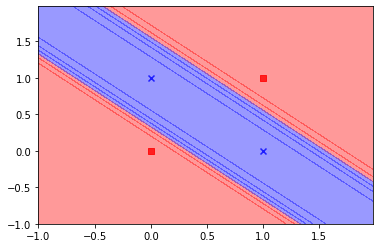

In [32]:
pesos_entrada = np.array([[ 1.74513663, -0.27294652, -6.6275564 ], [-5.30082191, 3.22929842, 4.35692107], [-5.30558028, 3.23342006, 4.35806833]])
pesos_oculta  = np.array([[-6.86268987], [ 4.76233485], [-9.14269281]]).reshape(3, 1)
pesos = [pesos_entrada, pesos_oculta]

#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 2, 1], pesos, debug = False)

executa_teste(X, y, rna)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


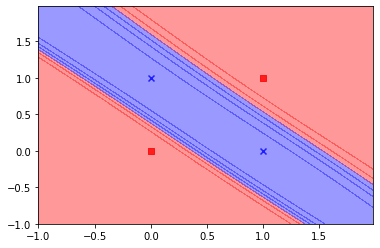

In [33]:
pesos_entrada = np.array([[5.10378148, -3.78632534, 0.66250704, 2.62357931],
                          [-3.49619324, 2.76223934, -0.05682757, -6.21572549],
                          [-3.30050094, 2.3181258, -2.4310841, -6.31661403]])
pesos_oculta  = np.array([[5.43682764], [-5.70623024], [1.39118148], [-10.48115125]]).reshape(4, 1)
pesos = [pesos_entrada, pesos_oculta]

#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 3, 1], pesos, debug = False)

executa_teste(X, y, rna)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


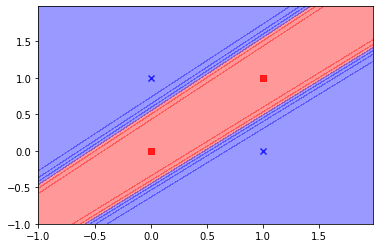

In [34]:
pesos_entrada = np.array([
    [0.64291678,  1.0687646,  -2.17271586,  1.72008825, -0.49919793],
    [2.62396607,  0.66895639, -4.10620446, -3.79047513, -1.37760389],
    [-2.59019417, -0.84127781,  4.0021083,   4.05260859,  1.44019994]]
)

pesos_oculta = np.array([
    [ 2.62754597, -3.13374301,  2.93417847,  0.57661113],
    [ 1.55446619, -1.56502148,  0.74014422, -0.4509503 ],
    [-3.92740136,  3.56712182, -0.17056196,  1.56390721],
    [ 0.317668,   -0.73097699, -5.87317236, -2.03965891],
    [ 0.21094803,  1.26986018, -1.72157615,  0.76014833]]
)

pesos_saida  = np.array([[-4.99443035], [4.29688676], [7.86155279], [2.30738465]]).reshape(4, 1)

pesos = [pesos_entrada, pesos_oculta, pesos_saida]

#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 4, 3, 1], pesos, debug = False)

executa_teste(X, y, rna)

# Resultados

Nesta tarefa foi pedido que fosse implementada uma rede neural do tipo feed forward, porém, sem o mecanismo de backward que é a etapa de ajuste dos pesos. Dessa maneira, implementamos uma rede neural contendo dois parâmetros, sendo o primeiro, o vetor de entrada que simboliza a arquitetura da rede neural, assim, um vetor \[2, 2, 1\]  significa que o programa construirá uma rede neural de 3 camadas, sendo uma oculta, e que na primeira e segunda camada existem dois neurônios, mais um neurônio de bias em cada camada, e na última camada, existe apenas um neurônio. O segundo parâmetro, é o vetor de pesos, ajustados manualmente para que a rede neural possa resolver o problema XOR apenas com a fase forward.

Foi implementado apenas o método forward, onde ocorre a multiplicação do vetor de pesos da camada pela entrada contendo o bias e esse resultado passa pela função sigmóide, para normalizar o resultado.

Porém, como foi solicitado apenas a fase forward sem um método de fit onde fosse possível ajustar os pesos, sem o parâmetro vetor de pesos previamente ajustados, a rede neural não conseguiria resolver o problema XOR de forma adequada.